# 7 AutoGen - GPT-4o

AutoGen is a framework that enables the development of LLM applications using multiple agents that can converse with each other to solve tasks. AutoGen agents are customizable, conversable, and seamlessly allow human participation. They can operate in various modes that employ combinations of LLMs, human inputs, and tools.

17/06/2024

<img src="https://raw.githubusercontent.com/retkowsky/images/master/autogenlogo.jpg">

> Documentation: https://microsoft.github.io/autogen/

In [1]:
import autogen
import matplotlib.pyplot as plt
import openai
import os
import pandas as pd
import sys

from autogen import Agent, AssistantAgent, ConversableAgent
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent
from autogen.code_utils import content_str
from PIL import Image

In [2]:
sys.version

'3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]'

In [3]:
WORK_DIR = "workdir"

os.makedirs(WORK_DIR, exist_ok=True)

In [4]:
config_list_4v = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4o"],
    },
)

In [5]:
config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": [
            "gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314",
            "gpt-4-32k-v0314"
        ],
    },
)

## 1. Example 1

<img src="https://github.com/retkowsky/images/blob/master/autogen_car_1.jpg?raw=true">

In [6]:
image_agent = MultimodalConversableAgent(
    name="image-explainer",
    max_consecutive_auto_reply=10,
    llm_config={
        "config_list": config_list_4v,
        "cache_seed": None,
        "temperature": 0.5,
        "max_tokens": 300
    },
)

user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="A human admin.",
    human_input_mode="NEVER",  # Try between ALWAYS or NEVER
    max_consecutive_auto_reply=0,
    code_execution_config={
        "use_docker": False
    },  # Please set use_docker=True if docker is available to run the generated code.
)

# Ask the question with an image
user_proxy.initiate_chat(
    image_agent,
    message="""What is this car?
<img https://github.com/retkowsky/images/blob/master/autogen_car_1.jpg?raw=true>.""",
)

User_proxy (to image-explainer):

What is this car?
<image>.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
image-explainer (to User_proxy):

The car in the image is a Ferrari Roma. The Ferrari Roma is a grand tourer produced by the Italian automotive manufacturer Ferrari. It features a sleek and elegant design, and it's known for its powerful performance and luxurious interior.

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': 'What is this car?\n<img https://github.com/retkowsky/images/blob/master/autogen_car_1.jpg?raw=true>.', 'role': 'assistant'}, {'content': "The car in the image is a Ferrari Roma. The Ferrari Roma is a grand tourer produced by the Italian automotive manufacturer Ferrari. It features a sleek and elegant design, and it's known for its powerful performance and luxurious interior.", 'role': 'user'}], summary="The car in the image is a Ferrari Roma. The Ferrari Roma is a grand tourer produced by the Italian automotive manufacturer Ferrari. It features a sleek and elegant design, and it's known for its powerful performance and luxurious interior.", cost={'usage_including_cached_inference': {'total_cost': 0, 'gpt-4o-2024-05-13': {'cost': 0, 'prompt_tokens': 373, 'completion_tokens': 45, 'total_tokens': 418}}, 'usage_excluding_cached_inference': {'total_cost': 0, 'gpt-4o-2024-05-13': {'cost': 0, 'prompt_tokens': 373, 'completion_tokens': 45, 't

<img src="https://github.com/retkowsky/images/blob/master/autogen_car_2.jpg?raw=true">

In [7]:
# Ask the question with an image
user_proxy.send(
    message="""What is this car?
<img https://github.com/retkowsky/images/blob/master/autogen_car_2.jpg?raw=trueg>

Make a summary of these cars""",
    recipient=image_agent,
)

User_proxy (to image-explainer):

What is this car?
<image>

Make a summary of these cars

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
image-explainer (to User_proxy):

The first car is a Ferrari Roma, a grand tourer known for its sleek and elegant design. It combines luxurious interiors with powerful performance, embodying the classic Ferrari style with modern touches.

The second car is a BMW X2, a compact luxury crossover SUV. It features a sporty design with BMW's signature kidney grille and a dynamic driving experience. The X2 is known for its agility, stylish appearance, and advanced technology.

--------------------------------------------------------------------------------


## 2. Example 2

<img src="https://github.com/retkowsky/images/blob/master/autogen_image_1.jpg?raw=true">

In [8]:
# Ask the question with an image
user_proxy.send(
    message="""Can you describe this image using hashtags and emojis?
<img https://github.com/retkowsky/images/blob/master/autogen_image_1.jpg?raw=true>

Make a summary""",
    recipient=image_agent,
)

User_proxy (to image-explainer):

Can you describe this image using hashtags and emojis?
<image>

Make a summary

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
image-explainer (to User_proxy):

#Paris2024 #Olympics 🗼🏅✨🌅

The image showcases the Eiffel Tower at sunset, with the Paris 2024 Olympics logo prominently displayed. The serene evening sky and the iconic Parisian landmark create a beautiful backdrop for the upcoming international sporting event. 🌇🌍🏆

--------------------------------------------------------------------------------


## 3. Example 3

In [9]:
class FigureCreator(ConversableAgent):
    def __init__(self, n_iters=2, **kwargs):
        """
        Initializes a FigureCreator instance.

        This agent facilitates the creation of visualizations through a collaborative effort among its child agents: 
        commander, coder, and critics.

        Parameters:
            - n_iters (int, optional): The number of "improvement" iterations to run. Defaults to 2.
            - **kwargs: keyword arguments for the parent AssistantAgent.
        """
        super().__init__(**kwargs)
        self.register_reply([Agent, None],
                            reply_func=FigureCreator._reply_user,
                            position=0)
        self._n_iters = n_iters

    def _reply_user(self, messages=None, sender=None, config=None):
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            logger.error(error_msg)
            raise AssertionError(error_msg)
        if messages is None:
            messages = self._oai_messages[sender]

        user_question = messages[-1]["content"]

        # Define the agents
        commander = AssistantAgent(
            name="Commander",
            human_input_mode="NEVER",
            max_consecutive_auto_reply=10,
            system_message="Help me run the code, and tell other agents it is in the <img result.jpg> file location.",
            is_termination_msg=lambda x: x.get("content", "").rstrip(
            ).endswith("TERMINATE"),
            code_execution_config={
                "last_n_messages": 3,
                "work_dir": WORK_DIR,
                "use_docker": False,
            },
            llm_config=self.llm_config,
        )

        critics = MultimodalConversableAgent(
            name="Critics",
            system_message="""Criticize the input figure. How to replot the figure so it will be better?
            Find bugs and issues for the figure.
            Pay attention to the color, format, and presentation. Keep in mind of the reader-friendliness.
            If you think the figures is good enough, then simply say NO_ISSUES""",
            llm_config={
                "config_list": config_list_4v,
                "max_tokens": 300,
                "cache_seed": None
            },
            human_input_mode="NEVER",
            max_consecutive_auto_reply=1,
            # use_docker=False,
        )

        coder = AssistantAgent(
            name="Coder",
            llm_config=self.llm_config,
        )

        coder.update_system_message(
            coder.system_message +
            "ALWAYS save the figure in 'plot.jpg' file. Tell other agents it is in the <img plot.jpg> file location."
        )

        # Data flow begins
        commander.initiate_chat(coder, message=user_question)
        img = Image.open(os.path.join(WORK_DIR, "plot.jpg"))
        plt.imshow(img)
        plt.axis("off")  # Hide the axes
        plt.show()

        for i in range(self._n_iters):
            commander.send(
                message=f"Improve <img {os.path.join(WORK_DIR, 'plot.jpg')}>",
                recipient=critics,
                request_reply=True,
            )

            feedback = commander._oai_messages[critics][-1]["content"]
            if feedback.find("NO_ISSUES") >= 0:
                break
            commander.send(
                message="Here is the feedback to your figure. Please improve! Save the result to 'final_plot.jpg'\n"
                + feedback,
                recipient=coder,
                request_reply=True,
            )
            img = Image.open(os.path.join(WORK_DIR, "final_plot.jpg"))
            plt.imshow(img)
            plt.axis("off")
            plt.show()

        return True, os.path.join(WORK_DIR, "final_plot.jpg")

In [10]:
gpt4_llm_config = {"config_list": config_list_gpt4, "cache_seed": None}

In [11]:
csv_url = "https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv"

df = pd.read_csv(csv_url)
df

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain
...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,rain
1457,2015-12-28,1.5,5.0,1.7,1.3,rain
1458,2015-12-29,0.0,7.2,0.6,2.6,fog
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun


In [12]:
df.shape

(1461, 6)

In [13]:
df.describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


User (to Figure Creator~):


Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low in a chart. The high temperature should be orange, 
the low temperature should be blue. All the labels should be visible. 


--------------------------------------------------------------------------------
Commander (to Coder):


Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low in a chart. The high temperature should be orange, 
the low temperature should be blue. All the labels should be visible. 


--------------------------------------------------------------------------------
Coder (to Commander):

To accomplish that, we'll use the pandas library to read the CSV data from the URL and process it, matplotlib to create the figure and chart, and seaborn to improve the visual appearance

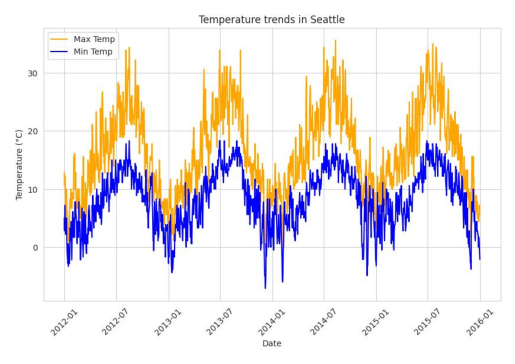

Commander (to Critics):

Improve <image>

--------------------------------------------------------------------------------
Critics (to Commander):

The plot you provided is informative, but there are several enhancements that could be made to improve its overall readability and aesthetic appeal. Here are some suggestions:

1. **Increase Font Sizes**:
   - Increase the font size for the title, axis labels, and tick labels to make them more readable.

2. **Legend Placement**:
   - Move the legend to the top left or top right inside the plot area. This conserves space and makes better use of the area.

3. **Grid Lines**:
   - Use lighter grid lines so they are less distracting.

4. **Line Transparency**:
   - Add some transparency to the lines (with the `alpha` parameter) to make the overlapping areas less cluttered.

5. **Simplify Date Labels**:
   - Rotate the x-axis date labels slightly or use a more readable format to prevent them from overlapping.

6. **Title**:
   - Make the title m

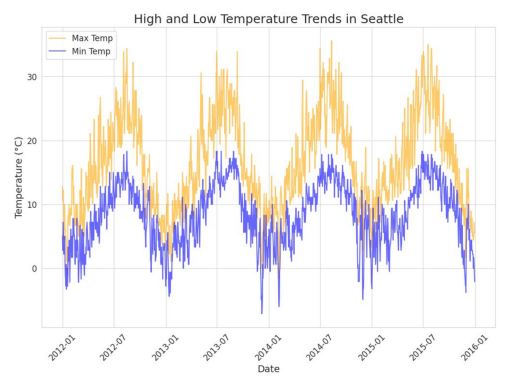

Commander (to Critics):

Improve <image>

--------------------------------------------------------------------------------
Commander (to Coder):

Here is the feedback to your figure. Please improve! Save the result to 'final_plot.jpg'
Improve <img workdir/plot.jpg>

--------------------------------------------------------------------------------
Coder (to Commander):

The user has not provided specifics concerning how they would like the figure altered. So, based on general best practices, I propose the following enhancements for the plot:

1. Provide the plot with a concise, descriptive title.
2. Clearly label both the x and y axes, and ensure the label fonts are large enough to read easily.
3. Modify the plot so that it's spacious, ensuring the figure isn't crowded.
4. Wherever they may assist in understanding the plot, incorporate gridlines.
5. To be easily distinguishable, ensure the colors of the data lines are sufficiently bold and contrast sharply with the background.

Please ex

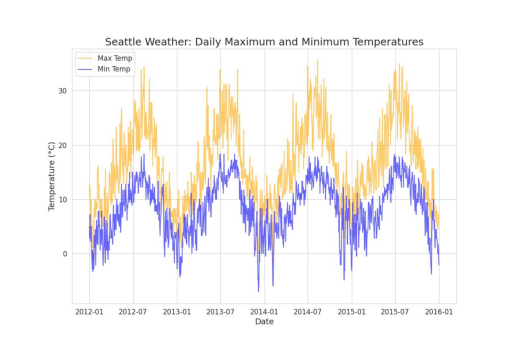

Figure Creator~ (to User):

workdir/final_plot.jpg

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': '\nPlot a figure by using the data from:\nhttps://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv\n\nI want to show both temperature high and low in a chart. The high temperature should be orange, \nthe low temperature should be blue. All the labels should be visible. \n', 'role': 'assistant'}, {'content': 'workdir/final_plot.jpg', 'role': 'user'}], summary='workdir/final_plot.jpg', cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])

In [20]:
creator = FigureCreator(name="Figure Creator~", llm_config=gpt4_llm_config)

user_proxy = autogen.UserProxyAgent(
    name="User",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=0,
    code_execution_config={"use_docker": False})

user_proxy.initiate_chat(
    creator,
    message="""
Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low in a chart. The high temperature should be orange, 
the low temperature should be blue. All the labels should be visible. 
""",
)

### First plot

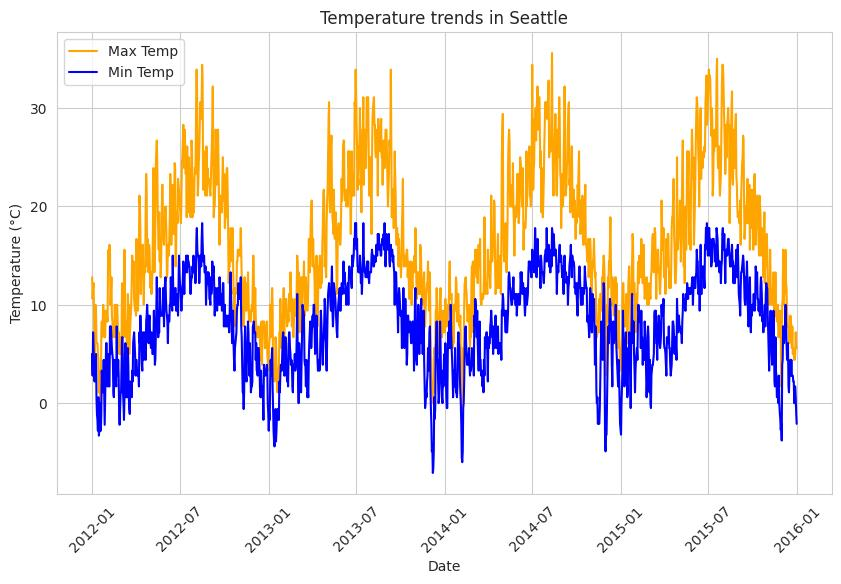

In [21]:
img = Image.open(os.path.join(WORK_DIR, 'plot.jpg'))
img

### Enhanced plot

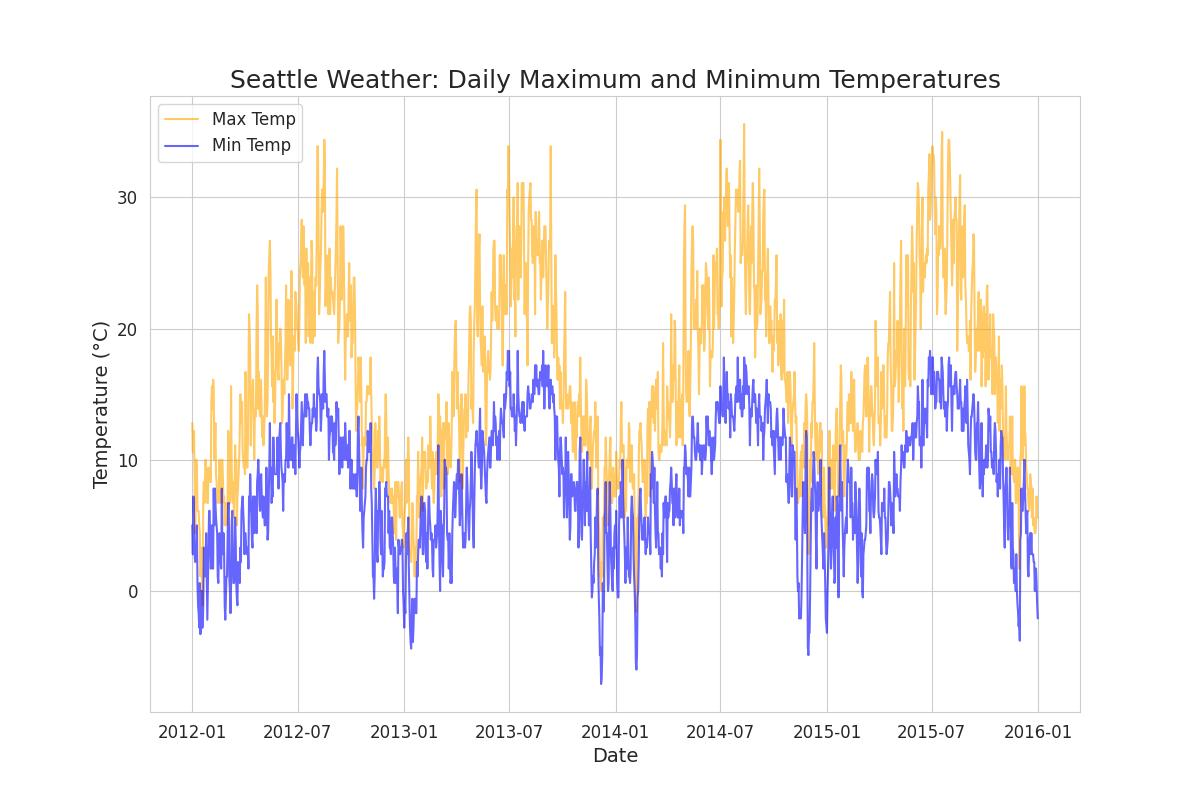

In [22]:
img = Image.open(os.path.join(WORK_DIR, 'final_plot.jpg'))
img

### Both images

In [23]:
def side_by_side_images(imagefile1, imagefile2):
    """
    Side by side images
    """
    # Display images side by side
    image1 = plt.imread(imagefile1)
    image2 = plt.imread(imagefile2)
    # Settings
    f, ax = plt.subplots(1, 2, figsize=(15, 8))
    ax[0].imshow(image1)
    ax[1].imshow(image2)
    ax[0].set_title('1. Initial plot')
    ax[1].set_title('2. Enhanced plot')
    #plt.tight_layout()
    plt.show()

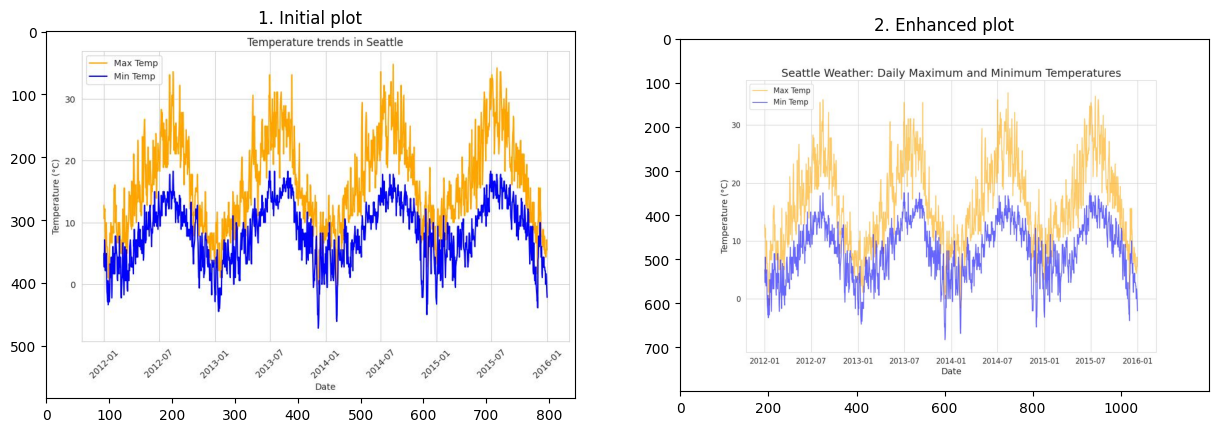

In [24]:
side_by_side_images(
    os.path.join(WORK_DIR, 'plot.jpg'),
    os.path.join(WORK_DIR, 'final_plot.jpg')
)

In [19]:
!ls $WORK_DIR/*.jpg -lh

-rwxrwxrwx 1 root root 223K Jun 19 09:05 workdir/final_plot.jpg
-rwxrwxrwx 1 root root 209K Jun 19 09:02 workdir/plot.jpg
